# Data Cleaning for Reddit Autos Selfposts<div class="tocSkip">
    
&copy; Jens Albrecht, 2021
    
This notebook can be freely copied and modified.  
Attribution, however, is highly appreciated.

<hr/>

See also: 

Albrecht, Ramachandran, Winkler: **Blueprints for Text Analytics in Python** (O'Reilly 2020)  
Chapter 4: [Preparing Data for Statistics and Machine Learning](https://learning.oreilly.com/library/view/blueprints-for-text/9781492074076/ch04.html#ch-preparation) + [Link to Github](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/README.md)

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [1]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/jsalbr/tdwi-2021-text-mining/raw/main'
    os.system(f'wget {GIT_ROOT}/notebooks/setup.py')

%run -i setup.py

You are working on a local system.
Files will be searched relative to "..".


## Load Python Settings<div class="tocSkip"/>

Common imports, defaults for formatting in Matplotlib, Pandas etc.

In [9]:
%run "$BASE_DIR/notebooks/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)
pd.options.plotting.backend = "matplotlib"

# path to import blueprints packages
sys.path.append(f'{BASE_DIR}/packages')

# Loading the Data Set

In [3]:
df = pd.read_csv(f"{BASE_DIR}/data/reddit-autos-selfposts-raw.csv", sep=";", decimal=".", parse_dates=['created'])

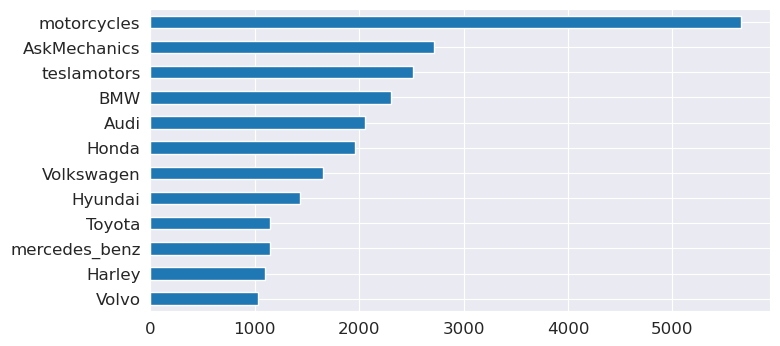

In [10]:
# plotly version
# df['subreddit'].value_counts().head(20).plot(kind='barh', height=500).update_yaxes(autorange="reversed")
df['subreddit'].value_counts().head(20).plot(kind='barh').invert_yaxis()

In [11]:
df.dtypes

subreddit               object
id                      object
created         datetime64[ns]
title                   object
text                    object
num_comments             int64
url                     object
dtype: object

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_comments,24712.00,11.61,33.58,0.00,2.00,5.00,11.00,1320.00


In [13]:
df.describe(include='O').T

,count,unique,top,freq
subreddit,24712,12,motorcycles,5654
id,24712,24712,m6t3eb,1
title,24712,24259,"Daily Discussion, Question and Answer, Experiences, and Support Thread",90
text,24712,24440,"If you are new here (or even if you're not), please skim through our [Rules](https://www.reddit.com/r/teslamotors/wiki/rules) to get more familiarity on potential updates or changes and what to ex...",52
url,24712,24712,https://www.reddit.com/r/motorcycles/comments/m6g9cm/ogio_mach_35_backpack_large_enough_for/,1


# Cleaning Text Data


In [14]:
text = """
After viewing the [PINKIEPOOL Trailer](https://www.youtu.be/watch?v=ieHRoHUg)
it got me thinking about the best match ups.
<lb>Here's my take:<lb><lb>[](/sp)[](/ppseesyou) Deadpool<lb>[](/sp)[](/ajsly)
Captain America<lb>"""

In [15]:
print(text)


After viewing the [PINKIEPOOL Trailer](https://www.youtu.be/watch?v=ieHRoHUg)
it got me thinking about the best match ups.
<lb>Here's my take:<lb><lb>[](/sp)[](/ppseesyou) Deadpool<lb>[](/sp)[](/ajsly)
Captain America<lb>


## Identify Noise with Regular Expressions


In [16]:
import re

RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

print(impurity(text))

0.09009009009009009


In [17]:
pd.options.display.max_colwidth = 200
# add new column to data frame
df['impurity'] = df['text'].progress_apply(impurity, min_len=10)

# get the top 3 records
df[['text', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

  0%|          | 0/24712 [00:00<?, ?it/s]

,text,impurity
4529,\[img\]https://i.imgur.com/ac4LgzZ.jpg\[/img\],0.17
6910,[\[url=https://ibb.co/ykmfVL7\]\[img\]](https://ibb.co/ykmfVL7)[https://i.ibb.co/8xnKXFt/20200802-IMG-4829-2.jpg\[/img\]\[/url\]](https://i.ibb.co/8xnKXFt/20200802-IMG-4829-2.jpg[/img][/url]),0.13
905,&amp;#x200B;\n\n![video](3v4jrqcbtn961),0.11


## Noise Removal with Regular Expressions


In [18]:
import html

def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text) 
    text = html.unescape(text) 
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [19]:
clean_text = clean(text)
print(clean_text)
print("Impurity:", impurity(clean_text))

After viewing the PINKIEPOOL Trailer it got me thinking about the best match ups. Here's my take: Deadpool Captain America
Impurity: 0.0


In [20]:
df['clean_text'] = df['text'].progress_map(clean)
df['impurity']   = df['clean_text'].apply(impurity, min_len=20)

df[['clean_text', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

  0%|          | 0/24712 [00:00<?, ?it/s]

,clean_text,impurity
18485,\#ford \#bmw \#funding \#battery \#filingsearch,0.21
6281,https://www.reddit.com/r/mercedes\_benz/comments/lidenp/time\_to\_post\_my\_first\_benz\_in\_2020\_i\_got\_this\_glc/,0.10
7662,"​ \\""Sea of Bimmers\\"", 2021. Photographer IG: JarosValdes",0.07


## Character Normalization with textacy


In [21]:
text = "The café “Saint-Raphaël” is loca-\nted on Côte dʼAzur."

In [22]:
import textacy
import textacy.preprocessing as tprep

def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text

print(normalize(text))

The cafe "Saint-Raphael" is located on Cote d'Azur.


In [23]:
df['clean_text'] = df['clean_text'].progress_map(normalize)

  0%|          | 0/24712 [00:00<?, ?it/s]

## Pattern-based Data Masking with textacy


In [24]:
from textacy.preprocessing.resources import RE_URL
from blueprints.exploration import count_words

count_words(df, column='clean_text', preprocess=RE_URL.findall).head(3)

  0%|          | 0/24712 [00:00<?, ?it/s]

,freq
token,
https://surveytime.app/research,5
https://imgur.com/a/MYmPkpn,5
https://uwmadison.co1.qualtrics.com/jfe/form/SV\_6le0oyYsSAdv1BQ,5


In [25]:
from textacy.preprocessing.replace import urls as replace_urls

text = "Check out https://spacy.io/usage/spacy-101"

# using default substitution _URL_
print(replace_urls(text))

Check out _URL_


In [26]:
df['clean_text'] = df['clean_text'].progress_map(replace_urls)

  0%|          | 0/24712 [00:00<?, ?it/s]

# Checkpoint: Save the Cleaned Data

In [27]:
df['text'] = df['title'] + ': ' + df['clean_text']

df[['subreddit', 'text']].sample(5)

,subreddit,text
19259,AskMechanics,Wanting to do an engine swap but need more info on different ones: Hi I'm going to be trying an engine swap within the next few years and I was wondering about different types of engines I could p...
889,Toyota,"Where do I find a RWD Celica?: They're some of my favorite JDM cars, especially 4th Gen Celicas. But since they're pretty rare, I hav a hard time finding them. Any recommendations?"
15079,motorcycles,"Rear brake failed and then came back?: Hey y'all. Something weird happened yesterday. Bike is a 2013 Yamaha Raider. I was out riding with a passenger, and as we were coming up on a stoplight, I en..."
2543,motorcycles,"Starting problem: I have a 78 gs 550e and have rebuilt the bike. The bike will start with easy start spray but will not sustain itself. Each carb had fuel in the bowl and has a new main jet, soon ..."
13285,Honda,is the honda eu2200i better than the Yamaha 2200ist for cabin cruiser boat application?: what is a better generator to put on a boat? the Yamaha 2200ist or the honda eu2200i?


In [28]:
df.drop(columns=['clean_text', 'impurity'], inplace=True)

In [29]:
df.to_csv("reddit-autos-selfposts-cleaned.csv", sep=";", decimal=".", index=False)